In [1]:
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm.auto as tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# uint8 is not popular
y_train = y_train.astype('i4')
y_test = y_test.astype('i4')

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype('f4')
x_test = x_test[..., tf.newaxis].astype('f4')
n_train = x_train.shape[0]

In [4]:
class CVAELatent(tfk.Model):
    def __init__(self, latent_dist_fn, n_params):
        super(CVAELatent, self).__init__()
        
        self.latent_dist_fn = latent_dist_fn
        self.latent_prior = self.latent_dist_fn()

        self.encoder = tfk.Sequential([
            tfk.layers.Input((28, 28, 1)),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Flatten(),
            tfk.layers.Dense(n_params),
            tfp.layers.DistributionLambda(
                make_distribution_fn=self.latent_dist_fn,
            ),
        ])

        self.decoder = tfk.Sequential([
            tfk.layers.Input(self.encoder.layers[-1].output_shape[0][1:]),
            tfk.layers.Dense(12*12*6, activation='relu'),
            tfk.layers.Reshape((12, 12, 6)),
            tfk.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=32, kernel_size=4, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=1, kernel_size=1),
        ])
    
    def encode(self, inputs):
        '''Encode
        '''
        dist = self.encoder(inputs)
        return dist
    
    def decode(self, inputs, logit=False):
        '''Decode
        '''
        out = self.decoder(inputs)
        if not logit:
            out = tf.sigmoid(out)
        return out
    
    def call(self, inputs, logit=False):
        out = self.encode(inputs)
        out = self.decode(out, logit=logit)
        return out

In [5]:
def make_dist(inputs=None, *args, **kwargs):
    nbern = 10
    ngaus = 4
    if inputs is None:
        bernp = tf.ones(nbern) * 0.1
        mean, var = tf.zeros(ngaus), tf.ones(ngaus)
    else:
        bernp, mean, var = tf.split(inputs, [nbern, ngaus, ngaus], axis=-1)
        # valid domain
        bernp, var = tf.nn.sigmoid(bernp), tf.math.softplus(var)
    return tfd.Blockwise([
        tfd.Independent(tfd.Bernoulli(probs=bernp, dtype=tf.float32), reinterpreted_batch_ndims=1),
        tfd.MultivariateNormalDiag(loc=mean, scale_diag=var),
    ])

model = CVAELatent(make_dist, 10 + 4*2)
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 18)                1

In [6]:
def analytic_kl(u1, s1, u2, s2):
    '''For two normal distributions'''
    return np.log(s2/s1) + (s1**2 + (u1 - u2)**2)/(2*(s2**2)) - .5

analytic_kl(.1, 1.1, 0, 1)

0.014689820195675218

In [7]:
optimizer = tfk.optimizers.Adam()

train_loss = tfk.metrics.Mean(name='train_loss')
test_loss = tfk.metrics.Mean(name='test_loss')

BATCH_SIZE = 100

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

In [8]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        latent = model.encode(images)
        kl = tf.reduce_mean(tfd.kl_divergence(latent, model.latent_prior))
        
        output = model.decode(latent, logit=True)
        dist = tf.nn.sigmoid_cross_entropy_with_logits(labels=images, logits=output)
        nll = tf.reduce_mean(tf.reduce_sum(dist, axis=[1, 2, 3]))
        
        loss = nll + kl

    trainable = model.trainable_variables
    gradients = tape.gradient(loss, trainable)
    optimizer.apply_gradients(zip(gradients, trainable))

    train_loss(loss)
    # return nll, kl

In [9]:
@tf.function
def test_step(images):
    output = model.call(images, logit=True)
    dist = tf.nn.sigmoid_cross_entropy_with_logits(labels=images, logits=output)
    nll = tf.reduce_mean(tf.reduce_sum(dist, axis=[1, 2, 3]))

    test_loss(nll)

In [10]:
EPOCHS = 100

history = defaultdict(list)

for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    optimizer.lr = 1e-3
    for images, labels in train_ds:
        train_step(images)

    for test_images, test_labels in test_ds:
        test_step(test_images)

    history['train_loss'].append(float(train_loss.result()))
    history['test_loss'].append(float(test_loss.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_loss.reset_states()
    

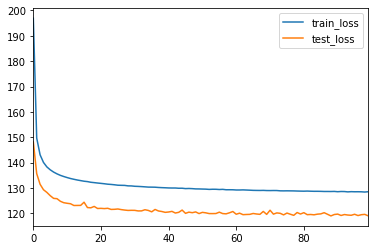

In [11]:
pd.DataFrame(history)[:].plot()

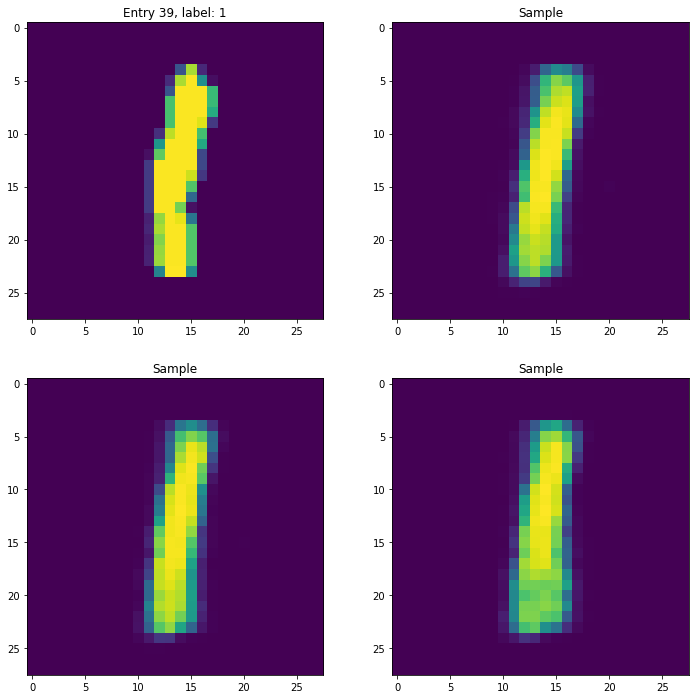

In [19]:
i = 39

ex = x_test[i,...,0]
lbl = y_test[i]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

axes[0][0].set_title("Entry %d, label: %d" % (i, lbl))
axes[0][0].imshow(ex)

latent = model.encode(ex[None, ..., None])

for ax in axes.flatten()[1:]:
    ax.set_title('Sample')
    ax.imshow(model.decode(latent.sample())[0, ..., 0])

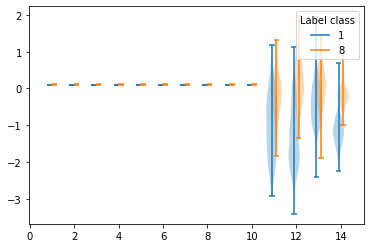

In [18]:
cut = y_test == 1
latent = model.encode(x_test[cut]).mean()
mlatent = latent.numpy()
vl1 = plt.violinplot(mlatent, positions=np.arange(mlatent.shape[1]) + .9)

cut = y_test == 8
latent = model.encode(x_test[cut]).mean()
mlatent = latent.numpy()
vl4 = plt.violinplot(mlatent, positions=np.arange(mlatent.shape[1]) + 1.1)

plt.legend([vl1['cbars'], vl4['cbars']], ['1', '8'], title='Label class')

In [20]:
latent = model.encode(x_test[1:2])
model.latent_prior.prob(latent.sample())

<tf.Tensor: id=147514, shape=(1,), dtype=float32, numpy=array([0.00196212], dtype=float32)>

In [21]:
latent.parameters['distribution'].parameters['distributions'][1].parameters

{'loc': <tf.Tensor: id=147260, shape=(1, 4), dtype=float32, numpy=
 array([[-0.4949572 , -1.3668076 ,  0.59546757,  0.62994856]],
       dtype=float32)>,
 'scale_diag': <tf.Tensor: id=147263, shape=(1, 4), dtype=float32, numpy=array([[0.07859865, 0.08289573, 0.08684158, 0.05829877]], dtype=float32)>,
 'scale_identity_multiplier': None,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'MultivariateNormalDiag'}

In [22]:
latent.parameters['distribution'].parameters['distributions'][0].parameters['distribution'].parameters

{'logits': None,
 'probs': <tf.Tensor: id=147262, shape=(1, 10), dtype=float32, numpy=
 array([[0.10231739, 0.10225618, 0.10228142, 0.10228238, 0.10225812,
         0.10229683, 0.10226989, 0.1022647 , 0.10224631, 0.10222394]],
       dtype=float32)>,
 'dtype': tf.float32,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'Bernoulli'}

In [23]:
latent.mean()

<tf.Tensor: id=147518, shape=(1, 14), dtype=float32, numpy=
array([[ 0.10231739,  0.10225618,  0.10228142,  0.10228238,  0.10225812,
         0.10229683,  0.10226989,  0.1022647 ,  0.10224631,  0.10222394,
        -0.4949572 , -1.3668076 ,  0.59546757,  0.62994856]],
      dtype=float32)>